In [50]:
from google.colab import files

uploaded = files.upload()

Saving Supplementary data 5.xlsx to Supplementary data 5.xlsx


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from xgboost import XGBClassifier

In [ ]:
cancer_data = pd.read_excel('/content/Supplementary data 1 (2) (2).xlsx')
cancer_data = cancer_data.apply(lambda x: x.str.rstrip() if x.dtype == "object" else x)

In [ ]:
cancer_data.loc[cancer_data['AFP'] == '>1210.00', 'AFP'] = 1210.00
cancer_data.loc[cancer_data['AFP'] == '>1210', 'AFP'] = 1210.00
cancer_data.loc[cancer_data['CA125'] == '>5000.00', 'CA125'] = 5000.00
cancer_data.loc[cancer_data['CA19-9'].isin(['>1000.00', '>1000']), 'CA19-9'] = 1000.00
cancer_data.loc[cancer_data['CA19-9'] == '<0.600', 'CA19-9'] = 0.5

In [ ]:
for col in cancer_data.drop('TYPE', axis=1).select_dtypes(include=['object']).columns:
    cancer_data[col] = pd.to_numeric(cancer_data[col], errors='coerce')

In [ ]:
cancer_data['TYPE'] = cancer_data['TYPE'].astype('int64')

In [ ]:
cancer_data_missing = cancer_data.copy()

In [ ]:
cols_to_drop = ['CA72-4']
cancer_data = cancer_data.drop(cols_to_drop, axis=1)

In [ ]:
imputer = SimpleImputer(strategy='median')
cancer_data_imputed = pd.DataFrame(imputer.fit_transform(cancer_data), columns=cancer_data.columns)

In [120]:
cancer_data_imputed.drop('SUBJECT_ID', inplace=True, axis=1)

In [121]:
X = cancer_data_imputed.drop('TYPE', axis=1)
y = cancer_data_imputed['TYPE']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [123]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [124]:
lasso = LassoCV(cv=5)
selector = SelectFromModel(lasso)
selector.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001082803623669415, tolerance: 0.0010317460317460316
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029939281219935054, tolerance: 0.0010317460317460316
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006307873816385867, tolerance: 0.0010317460317460316
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.

SelectFromModel(estimator=LassoCV(cv=5))

In [125]:
selected_features = X.columns[selector.get_support()]

In [126]:
selected_features

Index(['Age', 'ALB', 'Ca', 'CA125', 'CEA', 'HE4', 'LYM#', 'Menopause'], dtype='object')

In [127]:
X_train_transformed = X_train[selected_features]
X_test_transformed = X_test[selected_features]

In [128]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [129]:
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [130]:
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)

Best Parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [131]:
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [132]:
predictions_rf = best_rf_model.predict(X_test_transformed)

In [133]:
accuracy_rf = accuracy_score(y_test, predictions_rf)
print("Accuracy for RandomForest:", accuracy_rf)

Accuracy for RandomForest: 0.9714285714285714


In [78]:
print("Classification Report for RandomForest:\n", classification_report(y_test, predictions_rf))

Classification Report for RandomForest:
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.91        53
         1.0       0.89      0.94      0.92        52

    accuracy                           0.91       105
   macro avg       0.92      0.91      0.91       105
weighted avg       0.92      0.91      0.91       105



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Training the SVM model
basemodel_df = pd.DataFrame(columns=['Base Model', 'Accuracy'])
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_transformed, y_train)

# Predicting the target values for test data
test_preds = svm_model.predict(X_test_transformed)

accuracy = svm_model.score(X_test_transformed, y_test)
basemodel_df = basemodel_df.append({'Base Model': "SVM", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("SVM:")
print(classification_report(y_test, test_preds))

SVM:
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86        53
         1.0       0.82      0.94      0.87        52

    accuracy                           0.87       105
   macro avg       0.88      0.87      0.87       105
weighted avg       0.88      0.87      0.87       105



<ipython-input-25-8646d28d75fe>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  basemodel_df = basemodel_df.append({'Base Model': "SVM", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# create KNN classifier
knn = KNeighborsClassifier()
# train the model
knn.fit(X_train_transformed , y_train)

# Predicting the target values for test data
test_preds = knn.predict(X_test_transformed)

accuracy = knn.score(X_test_transformed, y_test)
basemodel_df = basemodel_df.append({'Base Model': "KNN", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("KNN:")
print(classification_report(y_test, test_preds))

KNN:
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76        53
         1.0       0.73      0.85      0.79        52

    accuracy                           0.77       105
   macro avg       0.78      0.77      0.77       105
weighted avg       0.78      0.77      0.77       105



<ipython-input-26-f51083fd5a53>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  basemodel_df = basemodel_df.append({'Base Model': "KNN", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# create decision tree classifier
clf = DecisionTreeClassifier(random_state=10)

# fit the model to the training data
clf.fit(X_train_transformed, y_train)

# predict on the test data
y_pred = clf.predict(X_test_transformed)

accuracy = clf.score(X_test_transformed, y_test)
basemodel_df = basemodel_df.append({'Base Model': "Decision Tree", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("Decision Trees:")
print(classification_report(y_test, y_pred))

Decision Trees:
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73        53
         1.0       0.72      0.75      0.74        52

    accuracy                           0.73       105
   macro avg       0.73      0.73      0.73       105
weighted avg       0.73      0.73      0.73       105



<ipython-input-27-d1f18bd1c3cc>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  basemodel_df = basemodel_df.append({'Base Model': "Decision Tree", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
from sklearn.metrics import accuracy_score

#  Create a dataframe to store the accuracy of ensemble models for further analysis
ensemble_df = pd.DataFrame(columns=['Ensemble Model', 'Accuracy'])
# importing voting classifier
from sklearn.ensemble import VotingClassifier

# Making the final model using voting classifier
vote_model = VotingClassifier(estimators=[('svc', svm_model), ('knn', knn), ('tree', clf)], voting='hard')

# training all the model on the train dataset
vote_model.fit(X_train_transformed, y_train)

# predicting the output on the test dataset
pred_final = vote_model.predict(X_test_transformed)

accuracy = vote_model.score(X_test_transformed, y_test)
ensemble_df = ensemble_df.append({'Ensemble Model': "Max Voting", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("Max Voting:")
print(classification_report(y_test, pred_final))

Max Voting:
              precision    recall  f1-score   support

         0.0       0.89      0.74      0.80        53
         1.0       0.77      0.90      0.83        52

    accuracy                           0.82       105
   macro avg       0.83      0.82      0.82       105
weighted avg       0.83      0.82      0.82       105



<ipython-input-28-d11819e149e3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ensemble_df = ensemble_df.append({'Ensemble Model': "Max Voting", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
!pip install vecstack

  Preparing metadata (setup.py) ... done
  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19861 sha256=cc93a88ef039f0d22a4b0c228a3484d44e7aee22346c8e98f31481731cae00ce
  Stored in directory: /root/.cache/pip/wheels/b8/d8/51/3cf39adf22c522b0a91dc2208db4e9de4d2d9d171683596220
Successfully built vecstack


In [ ]:
from vecstack import stacking

# putting all base model objects in one list
all_models = [svm_model, clf, knn]

# computing the stack features
s_train, s_test = stacking(all_models,                     # list of models
                           X_train_transformed, y_train, X_test_transformed,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           n_folds=5,                  # number of folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=1)                  # print all info
# initializing the second-level model
final_model = clf

# fitting the second level model with stack features
final_model = final_model.fit(s_train, y_train)

# predicting the final output using stacking
pred_final = final_model.predict(s_test)

accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Stacking", 'Accuracy': accuracy}, ignore_index=True)

# calculate accuracy score
# evaluate the model on the test set
print("Stacking:")
print(classification_report(y_test, pred_final))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVC]
    ----
    MEAN:     [0.78282313] + [0.04913642]
    FULL:     [0.78278689]

model  1:     [DecisionTreeClassifier]
    ----
    MEAN:     [0.81955782] + [0.04013173]
    FULL:     [0.81967213]

model  2:     [KNeighborsClassifier]
    ----
    MEAN:     [0.81573129] + [0.03345156]
    FULL:     [0.81557377]

Stacking:
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86        53
         1.0       0.82      0.94      0.87        52

    accuracy                           0.87       105
   macro avg       0.88      0.87      0.87       105
weighted avg       0.88      0.87      0.87       105



<ipython-input-30-a06c54a4cae0>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ensemble_df = ensemble_df.append({'Ensemble Model': "Stacking", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
# importing bagging module for Bagging Method
from sklearn.ensemble import BaggingClassifier

# initializing the bagging model using XGboost as base model with default parameters
bag_model = BaggingClassifier(base_estimator=svm_model)

# training model
bag_model.fit(X_train_transformed, y_train)

# predicting the output on the test dataset
pred = bag_model.predict(X_test_transformed)
pred = np.around(pred).astype("int64") # convert probabilities to labels

# calculate accuracy score

accuracy = accuracy_score(y_test, pred)
ensemble_df = ensemble_df.append({'Ensemble Model': "Bagging", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Bagging:")
print(classification_report(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging:
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86        53
         1.0       0.82      0.94      0.87        52

    accuracy                           0.87       105
   macro avg       0.88      0.87      0.87       105
weighted avg       0.88      0.87      0.87       105



<ipython-input-31-0492d4471bde>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ensemble_df = ensemble_df.append({'Ensemble Model': "Bagging", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
# importing machine learning models for prediction
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# initializing the boosting module with default parameters
model = GradientBoostingClassifier()
xgb_model = XGBClassifier()

# training the model on the train dataset
#model.fit(X_train, y_train)
xgb_model.fit(X_train_transformed, y_train)

# predicting the output on the test dataset
pred_final = xgb_model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Boosting", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Boosting:")
print(classification_report(y_test, pred_final))

Boosting:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        53
         1.0       0.88      0.88      0.88        52

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.89       105
weighted avg       0.89      0.89      0.89       105



<ipython-input-32-f2db3d748d0d>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ensemble_df = ensemble_df.append({'Ensemble Model': "Boosting", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
# Combining all ensemble models; (bagging, boosting, max_vote) with stacking
# importing stacking lib
from vecstack import stacking

# putting all base model objects in one list
all_models = [xgb_model, vote_model, bag_model]

# computing the stack features
s_train, s_test = stacking(all_models,                     # list of models
                           X_train_transformed, y_train, X_test_transformed,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           n_folds=5,                  # number of folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=1)                  # print all info

# initializing the second-level model
final_model = xgb_model

# fitting the second level model with stack features
final_model = final_model.fit(s_train, y_train)

# predicting the final output using stacking
pred_final = final_model.predict(s_test)

# calculate accuracy score

accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Ensemble Combination", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Stacking:")
print(classification_report(y_test, pred_final))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    ----
    MEAN:     [0.87304422] + [0.02337368]
    FULL:     [0.87295082]

model  1:     [VotingClassifier]
    ----
    MEAN:     [0.84846939] + [0.02390893]
    FULL:     [0.84836066]

model  2:     [BaggingClassifier]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


    ----
    MEAN:     [0.81139456] + [0.03554544]
    FULL:     [0.81147541]

Stacking:
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87        53
         1.0       0.84      0.92      0.88        52

    accuracy                           0.88       105
   macro avg       0.88      0.88      0.88       105
weighted avg       0.88      0.88      0.88       105



<ipython-input-33-55f5d04a1c3b>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ensemble_df = ensemble_df.append({'Ensemble Model': "Ensemble Combination", 'Accuracy': accuracy}, ignore_index=True)


In [ ]:
from vecstack import stacking

# putting all base model objects in one list
all_models = [xgb_model,best_rf_model ]

# computing the stack features
s_train, s_test = stacking(all_models,                     # list of models
                           X_train_transformed, y_train, X_test_transformed,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           n_folds=5,                  # number of folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=1)                  # print all info

# initializing the second-level model
final_model = xgb_model

# fitting the second level model with stack features
final_model = final_model.fit(s_train, y_train)

# predicting the final output using stacking
pred_final = final_model.predict(s_test)

# calculate accuracy score

accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Ensemble Combination", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Stacking:")
print(classification_report(y_test, pred_final))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [XGBClassifier]
    ----
    MEAN:     [0.87304422] + [0.02337368]
    FULL:     [0.87295082]

model  1:     [RandomForestClassifier]
    ----
    MEAN:     [0.87287415] + [0.01594019]
    FULL:     [0.87295082]

Stacking:
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89        53
         1.0       0.86      0.94      0.90        52

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105



<ipython-input-34-25c0320ea2d5>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ensemble_df = ensemble_df.append({'Ensemble Model': "Ensemble Combination", 'Accuracy': accuracy}, ignore_index=True)


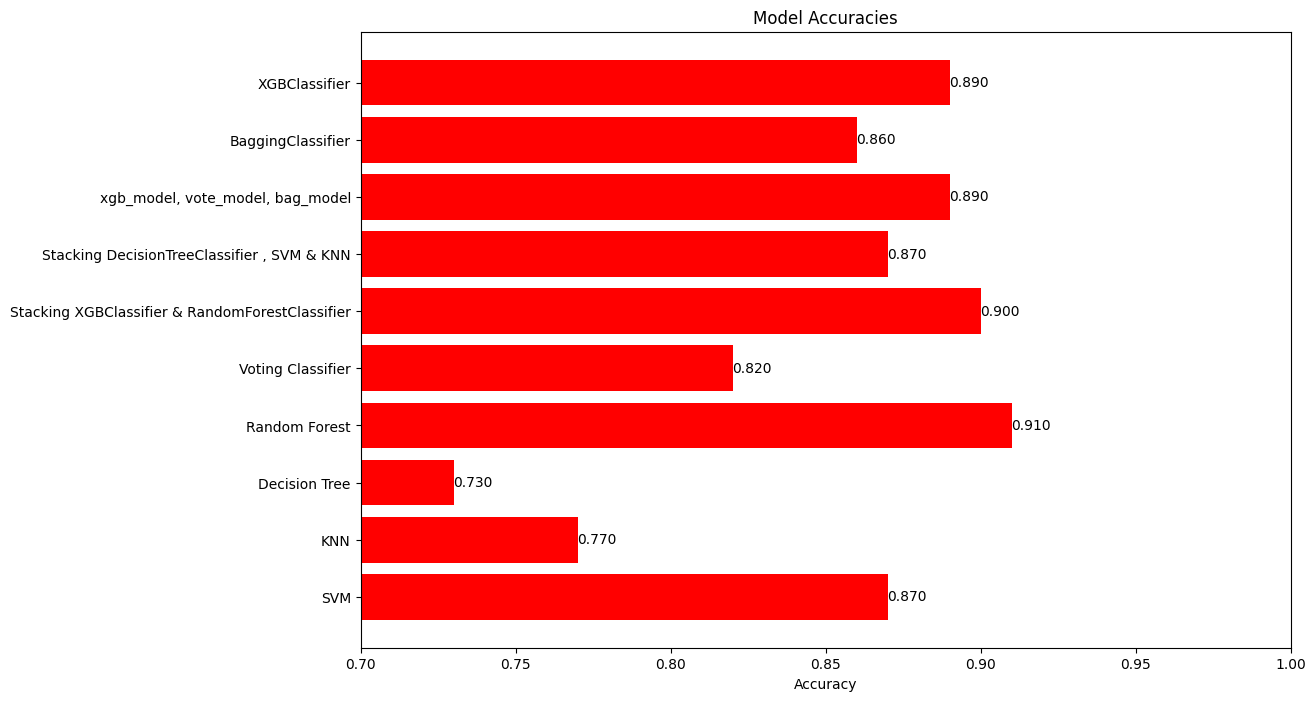

In [ ]:
import matplotlib.pyplot as plt

# Replace these with the accuracies obtained from your models
accuracies = {
    'SVM': 0.87,
    'KNN': 0.77,
    'Decision Tree': 0.73,
    'Random Forest': 0.91,
    'Voting Classifier': 0.82,
    'Stacking XGBClassifier & RandomForestClassifier': 0.9,
    'Stacking DecisionTreeClassifier , SVM & KNN': 0.87,
    'xgb_model, vote_model, bag_model':0.89,
    'BaggingClassifier': 0.86,
    'XGBClassifier': 0.89
}

# Create lists for models and their corresponding accuracies
models = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Plotting the bar graph
plt.figure(figsize=(12, 8))
plt.barh(models, accuracy_values, color='red')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.xlim(0.7, 1.0)  # Adjust the x-axis limits if needed

# Display the accuracy values on the bars
for index, value in enumerate(accuracy_values):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.show()


In [ ]:
import numpy as np
import pandas as pd

file_path = '/content/Supplementary data 1 (2) (2).xlsx'
features_list = ['AFP', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BASO#', 'BUN', 'Ca',
                 'CA19-9', 'CEA', 'CL', 'CREA', 'EO%', 'GLO', 'HE4', 'HGB', 'IBIL',
                 'LYM%', 'MCH', 'Menopause', 'MONO#', 'Na', 'NEU', 'PDW']
data = pd.read_excel(file_path, usecols=features_list)
total_rows = len(data)
try:
    row_number = int(input(f"Enter the row number (1 to {total_rows}) for prediction: "))
    if 1 <= row_number <= total_rows:

        selected_row = data.iloc[row_number - 1]
        user_input = np.array(selected_row).reshape(1, -1)

        predicted_output = best_rf_model.predict(user_input)

        if predicted_output[0] == 1:
            print(f"For row {row_number}, the predicted output indicates Ovarian Cancer.")
        else:
            print(f"For row {row_number}, the predicted output does not indicate Ovarian Cancer.")
    else:
        print(f"Please enter a valid row number between 1 and {total_rows}.")
except ValueError:
    print("Invalid input. Please enter a valid row number.")



In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier

# Assuming 'best_rf_model' is your trained RandomForestClassifier from GridSearchCV
# Use the best model obtained from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_transformed)



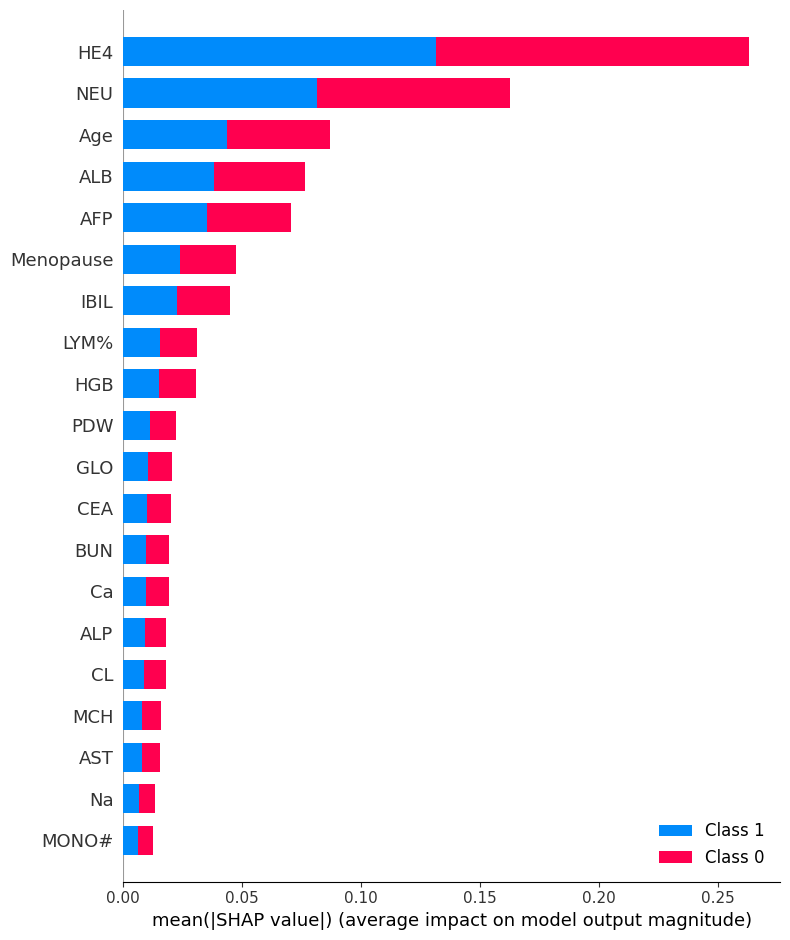

In [ ]:
# Summary plot (global interpretation of feature importance)
shap.summary_plot(shap_values, X_test_transformed)